## 绝地求生探索性数据分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# 忽略warnings错误提示

In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


* **Id** - 用户id
* **groupId** - 所处小队id
* **matchId** - 该场比赛id
* **assists** - 助攻数
* **boosts** - 使用能量道具数量
* **damageDealt** - 总伤害
* **DBNOs** - 击倒敌人数量
* **headshotKills** - 爆头数
* **heals** - 使用治疗药品数量
* **killPlace** - 本场比赛杀敌排行
* **killPoints** - Elo杀敌排名
* **kills** - 杀敌数
* **killStreaks** - 连续杀敌数
* **logestKill** - 最远杀敌距离
* **matchDuration** - 比赛时长
* **matchType** - 比赛类型（小组人数）
* **maxPlace** - 本局最差名词
* **numGroups** - 小组数目
* **rankPoints** - Elo排名
* **rideDistance** - 驾车距离
* **roadKills** - 驾车杀敌数
* **swimDistance** - 游泳距离
* **teamKills** - 杀死队友的次数
* **vehicleDestroys** - 毁坏机动车的数量
* **walkDistance** - 步行距离
* **weaponsAcquired** - 收集武器数量
* **winPoints** -胜率Elo排名
* **wimPlacePerc** - 百分比排名

In [4]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


以上为数据总览，接下来进行数据探索。

### The Killers

In [5]:
print("平均击杀 {:.4f} 玩家，99%的玩家击杀人数在{}人或以下，最大击杀人数{}。".format(train['kills'].mean(), train['kills'].quantile(0.99), train['kills'].max()))

平均击杀 0.9248 玩家，99%的玩家击杀人数在7.0人或以下，最大击杀人数72。


下面通过可视化来进行分析。

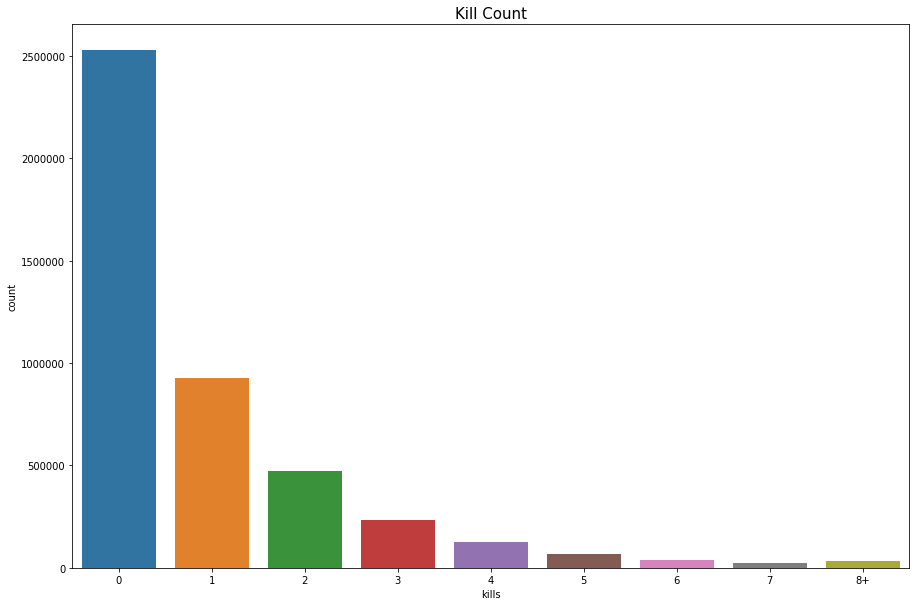

In [6]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count", fontsize=15)
plt.show()

从上图我们可以看出，绝大部分玩家击杀人数为0，那么他们是否对敌人造成了伤害？

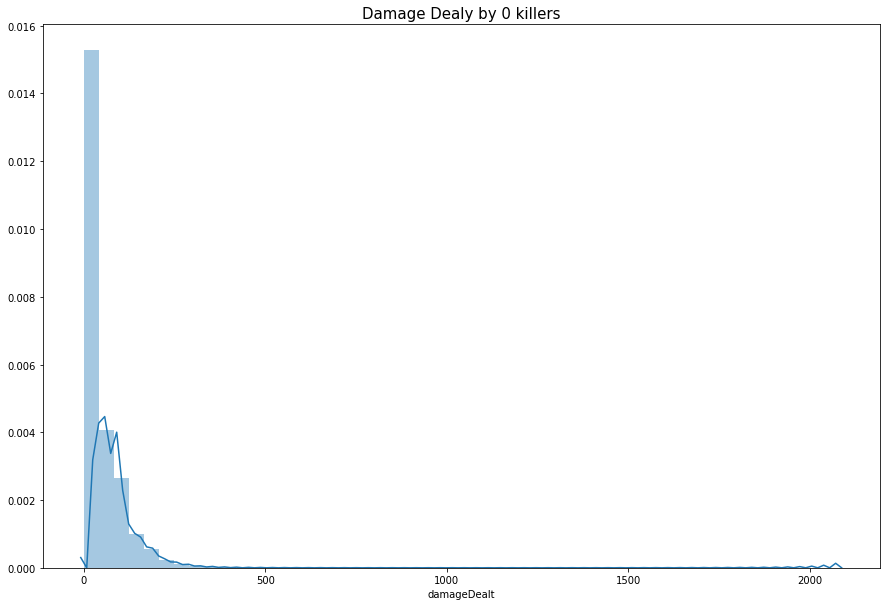

In [7]:
data = train.copy()
data = data[data['kills'] == 0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealy by 0 killers", fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

击杀数为0的玩家大部分也没有对敌人造成伤害，我们接下来对例外情况进行分析。

In [8]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))

data1 = train[train['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

16666 players (0.3748%) have won without a single kill!
4770 players (0.1073%) have won without dealing damage!


胜率与击杀数的关系。

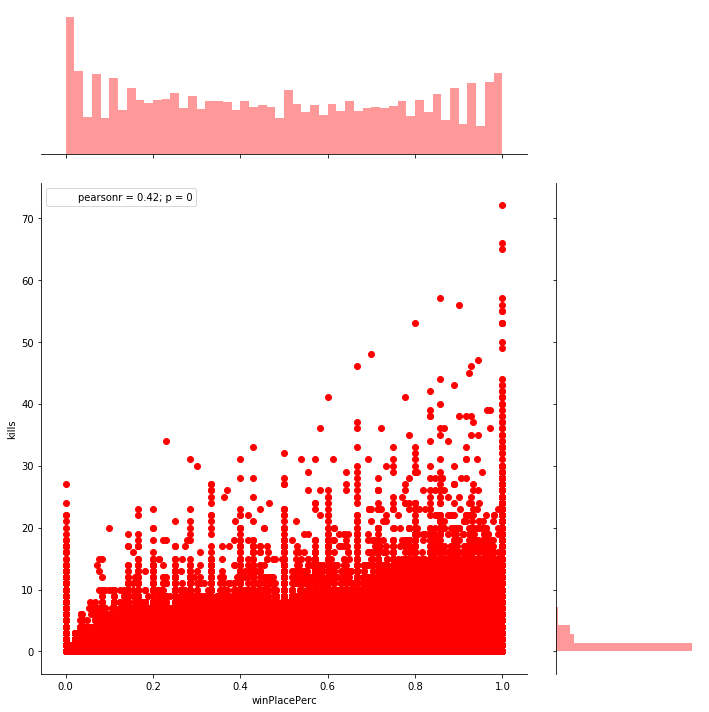

In [9]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, size=10, ratio=3, color="r")
# size: 设置图表大小
plt.show()

由以上结果可知，击杀数与能够赢得游戏有很大关系。现在我们将玩家分组，分为 0 kills, 1-2 kills, 3-5 kills, 6-10 kills 和 10+ kills。

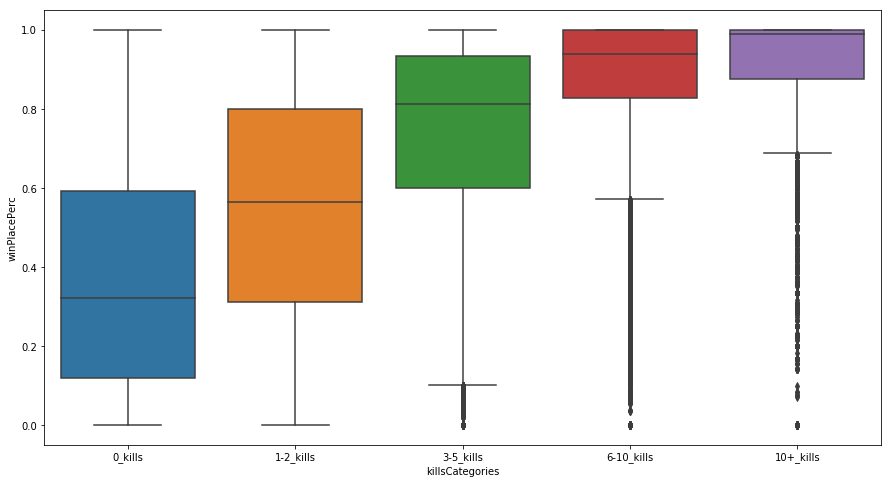

In [10]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x='killsCategories', y='winPlacePerc', data=kills)
plt.show()

### The Runners

In [11]:
print("每个玩家平均走了 {:.1f} 米, 99% 的玩家移动距离在 {} 米或以下, 移动距离最长为 {} 米.".format(train['walkDistance'].mean(), train['walkDistance'].quantile(0.99), train['walkDistance'].max()))

每个玩家平均走了 1154.2 米, 99% 的玩家移动距离在 4396.0 米或以下, 移动距离最长为 25780.0 米.


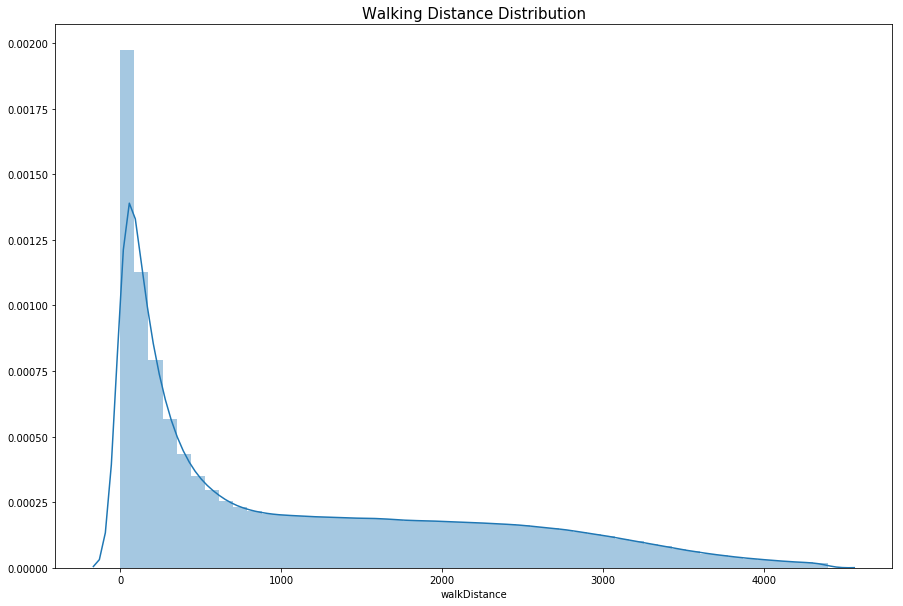

In [12]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution", fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

In [13]:
print("{} players ({:.4f}%) walked 0 meters. This means that they died before taking a step or they are afk(more possible).".format(len(data[data['walkDistance']==0]), 100*len(data[data['walkDistance']==0])/len(train)))

99603 players (2.2398%) walked 0 meters. This means that they died before taking a step or they are afk(more possible).


#### 移动距离与胜率的关系

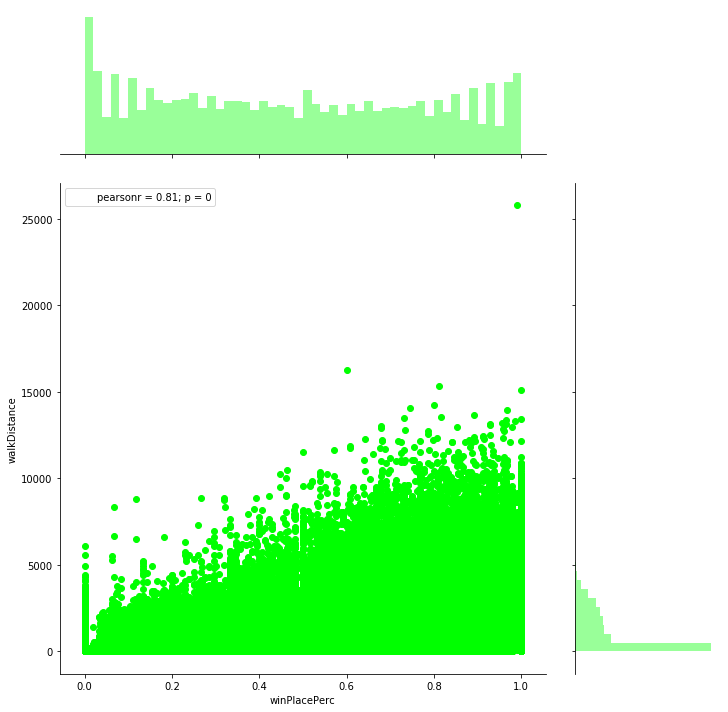

In [14]:
sns.jointplot(x='winPlacePerc', y='walkDistance', data=train, size=10, ratio=3, color='lime')
plt.show()

从上图可以明显地看出，移动距离与胜率也有很大的关系。

### The Drivers

In [15]:
print("The average person drives for {:.1f}m, 99% of people have drived {}m or less, while the formula 1 champion drived for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

The average person drives for 606.1m, 99% of people have drived 6966.0m or less, while the formula 1 champion drived for 40710.0m.


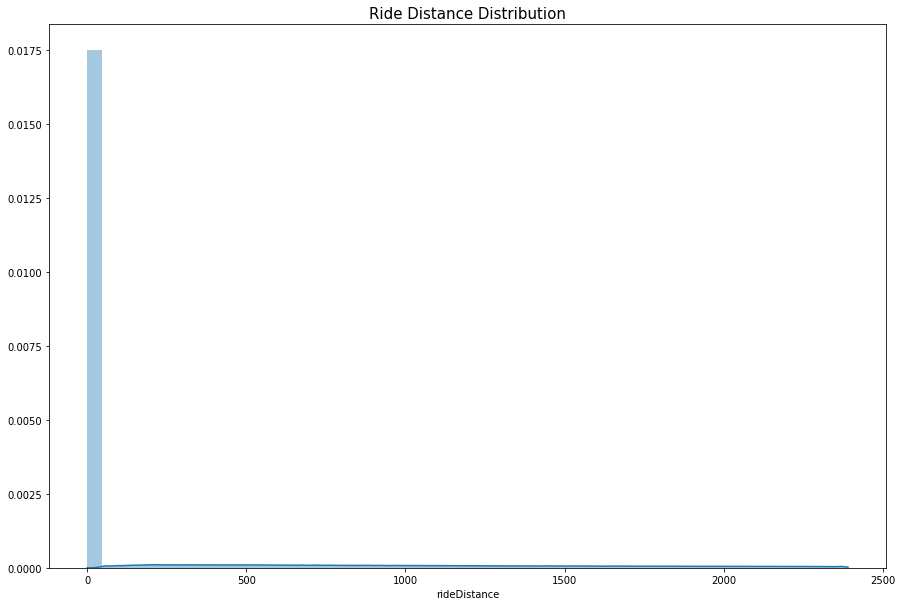

In [16]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.9)]
plt.figure(figsize=(15,10))
plt.title('Ride Distance Distribution', fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [17]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they don't have a driving licence yet.".format(len(data[data['rideDistance']==0]), 100*len(data[data['rideDistance']==0])/len(train)))

3309429 players (74.4199%) drived for 0 meters. This means that they don't have a driving licence yet.


可以看出，74%左右的玩家在游戏过程中并没有使用交通工具。下面绘制相关图像。

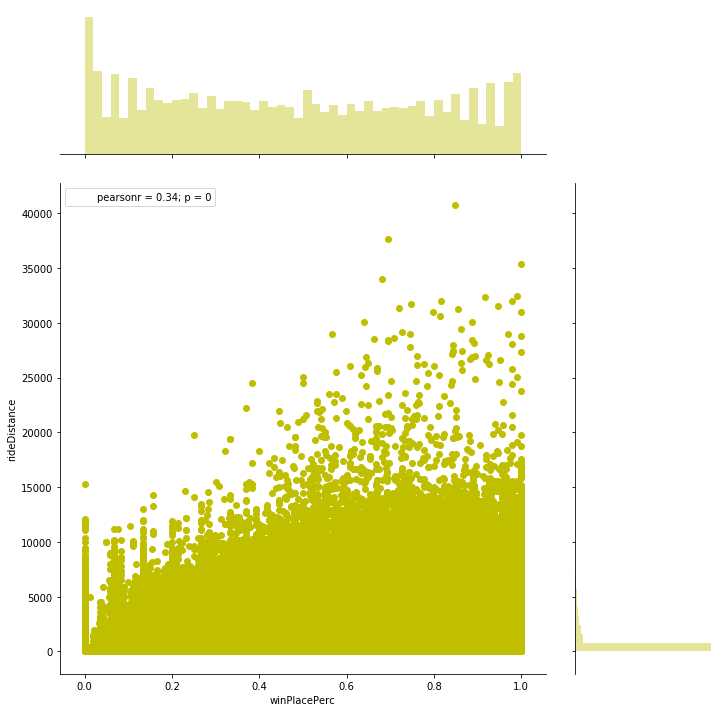

In [18]:
sns.jointplot(x='winPlacePerc', y='rideDistance', data=train, size=10, ratio=3, color='y')
plt.show()

由上图我们可以看出，胜率与骑行距离有一定关系，但是关系不大。

下面将分析毁坏交通工具的数量（vehicleDestroys）与胜率之间的关系。

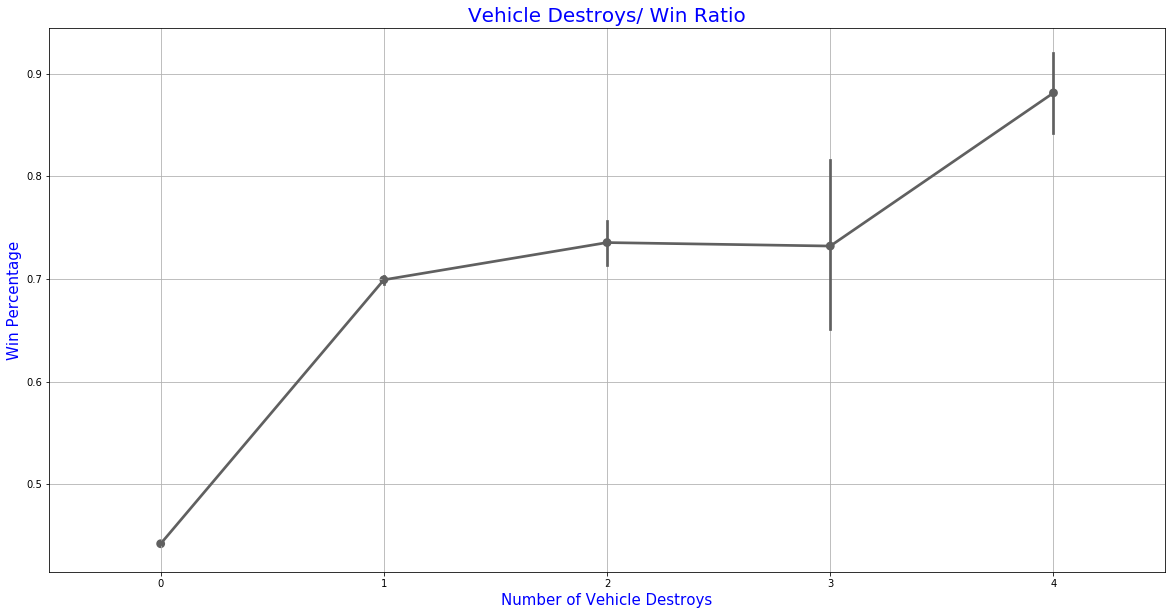

In [19]:
f, ax1 = plt.subplots(figsize=(20,10))
sns.pointplot(x='vehicleDestroys', y='winPlacePerc', data=data, color='#606060', alpha=0.8)
plt.xlabel('Number of Vehicle Destroys', fontsize=15, color='blue')
plt.ylabel('Win Percentage', fontsize=15, color='blue')
plt.title('Vehicle Destroys/ Win Ratio', fontsize=20, color='blue')
plt.grid()
plt.show()

由上图可以看出，随着毁坏交通工具的数量增加，胜率也随之增加，二者有较强的相关性。

### The Swimmers

In [20]:
print("The average person swims for {:.1f}m, 99% of people have swimed {}m or less, while the olympic champion swimmed for {}m.".format(train['swimDistance'].mean(), train['swimDistance'].quantile(0.99), train['swimDistance'].max()))

The average person swims for 4.5m, 99% of people have swimed 123.0m or less, while the olympic champion swimmed for 3823.0m.


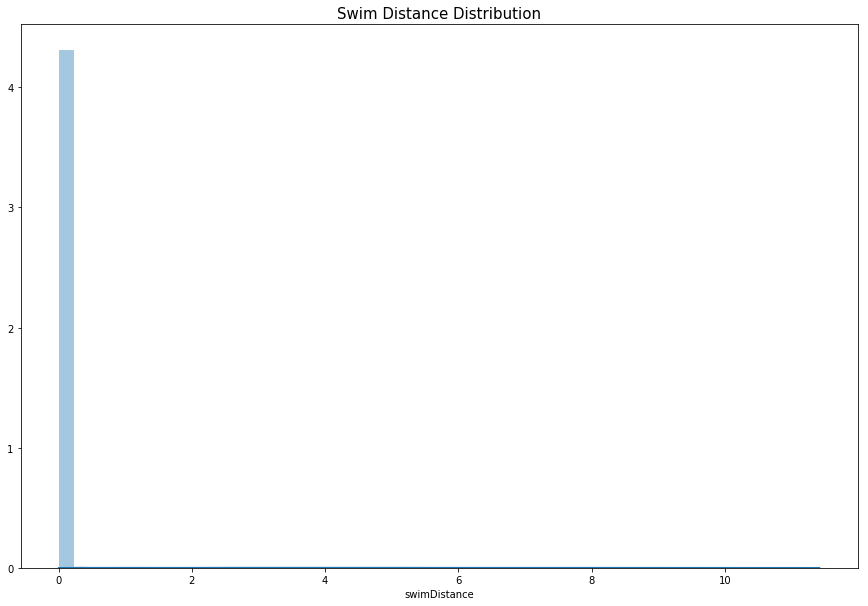

In [21]:
data = train.copy()
data = data[data['swimDistance'] < train['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,10))
plt.title("Swim Distance Distribution", fontsize=15)
sns.distplot(data['swimDistance'])
plt.show()

有上图可以看出，基本上没有人在游戏中游泳。接下来将游泳距离分为4个区间，并绘制箱型图。

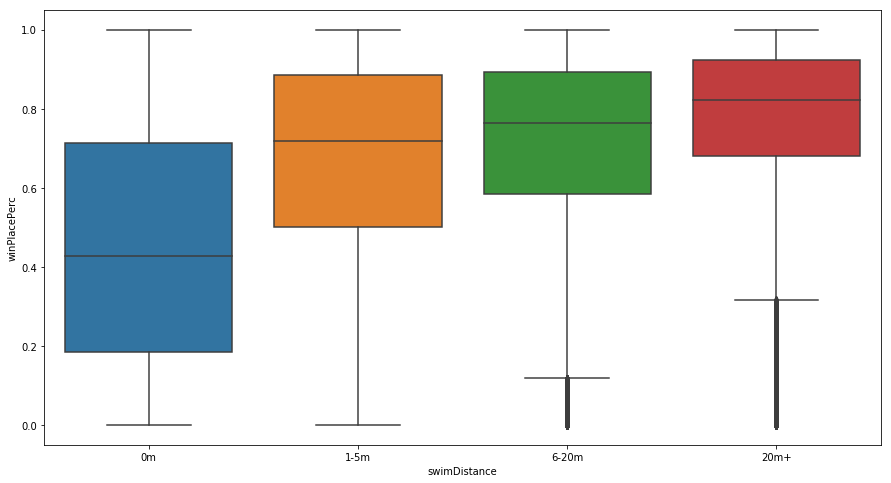

In [22]:
swim = train.copy()
swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1,0,5,20,3823], labels=['0m','1-5m','6-20m','20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x='swimDistance', y='winPlacePerc', data=swim)
plt.show()

### The Healers

In [23]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))

print("The average person uese {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

The average person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
The average person uese 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


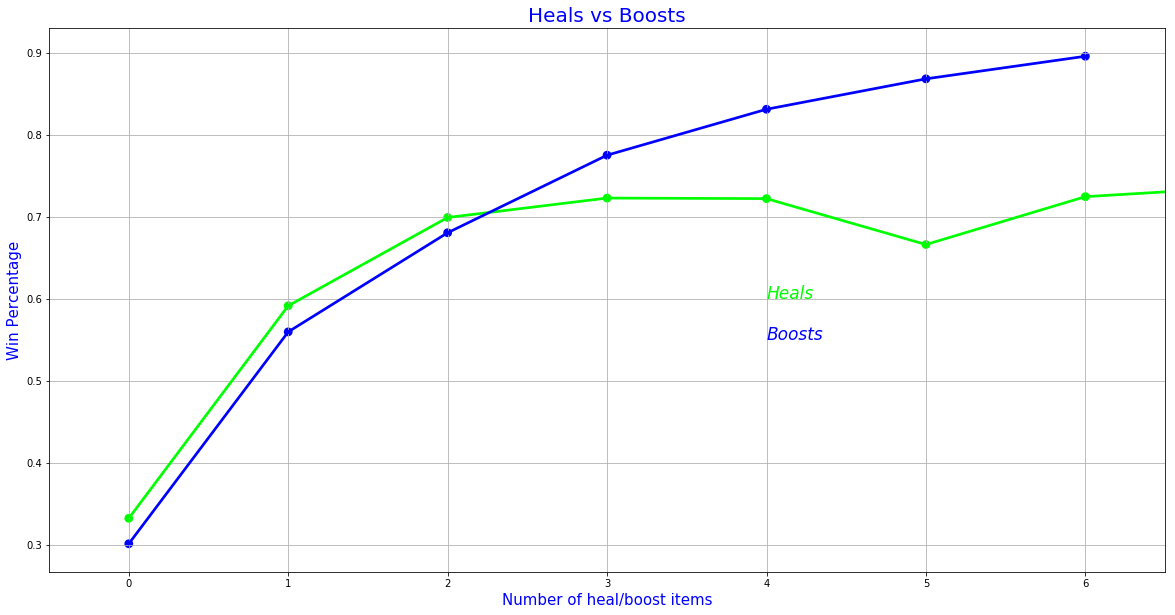

In [24]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f, ax1 = plt.subplots(figsize=(20,10))
sns.pointplot(x='heals', y='winPlacePerc', data=data, color='lime', alpha=0.8)
sns.pointplot(x='boosts', y='winPlacePerc', data=data, color='blue', alphs=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize=17,style='italic')
# 给图表添加文本注释
plt.text(4,0.55,'Boosts',color='blue',fontsize=17, style='italic')
plt.xlabel('Number of heal/boost items', fontsize=15, color='blue')
plt.ylabel('Win Percentage', fontsize=15, color='blue')
plt.title('Heals vs Boosts', fontsize=20, color='blue')
plt.grid()
plt.show()

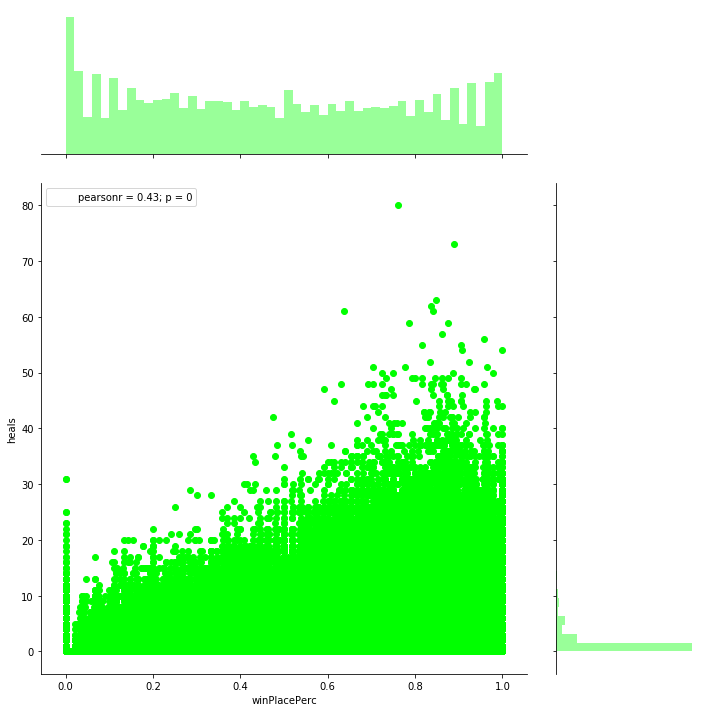

In [25]:
sns.jointplot(x='winPlacePerc', y='heals', data=train, size=10, ratio=3, color='lime')
plt.show()

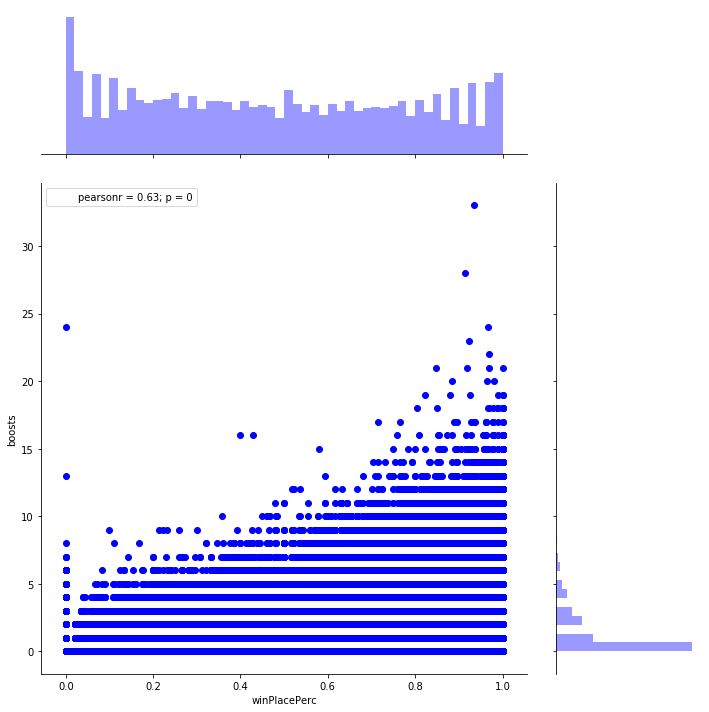

In [26]:
sns.jointplot(x='winPlacePerc', y='boosts', data=train, size=10, ratio=3, color='blue')
plt.show()

由上可知，药品和饮料使用量与胜率有较大相关性。

### Solos, Duos and Squads

游戏有3种模式，单排、双排和四排。所以100个玩家在一局游戏中，将有50队双排或者25队四排。

In [27]:
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)]
squads = train[train['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}) duos games and {} ({:.2f}) squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train)))

There are 709111 (15.95%) solo games, 3295326 (74.10) duos games and 442529 (9.95) squad games.


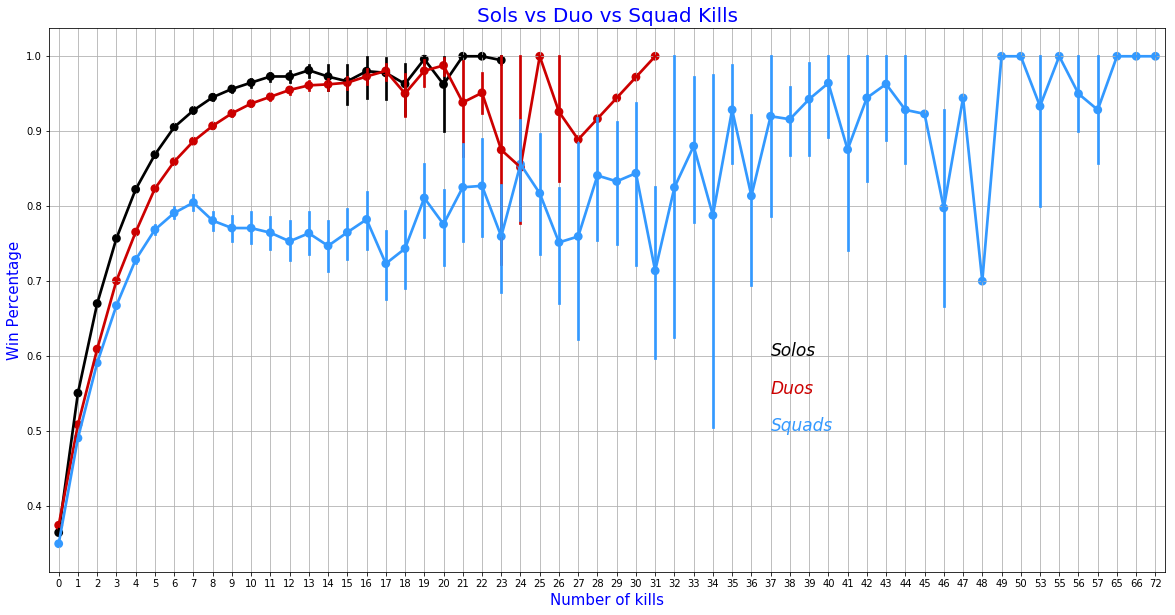

In [28]:
f,ax1 = plt.subplots(figsize=(20,10))
sns.pointplot(x='kills',y='winPlacePerc', data=solos, color='black', alpha=0.8)
sns.pointplot(x='kills', y='winPlacePerc', data=duos, color='#CC0000', alpha=0.8)
sns.pointplot(x='kills', y='winPlacePerc', data=squads, color='#3399FF', alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize=17,style='italic')
plt.text(37,0.55, 'Duos', color='#CC0000', fontsize=17, style='italic')
plt.text(37, 0.5, 'Squads', color='#3399FF', fontsize=17, style='italic')
plt.xlabel('Number of kills', fontsize=15, color='blue')
plt.ylabel('Win Percentage', fontsize=15, color='blue')
plt.title('Sols vs Duo vs Squad Kills', fontsize=20, color='blue')
plt.grid()
plt.show()

由上图可知，单排或双排时，击杀数与胜率具有较大相关性。但是在四排时，随着击杀数增加，胜率波动严重，相关性不清晰。

接下来对击倒数（DBNOs）、助攻数（assist）和救活数（revive）进行分析。

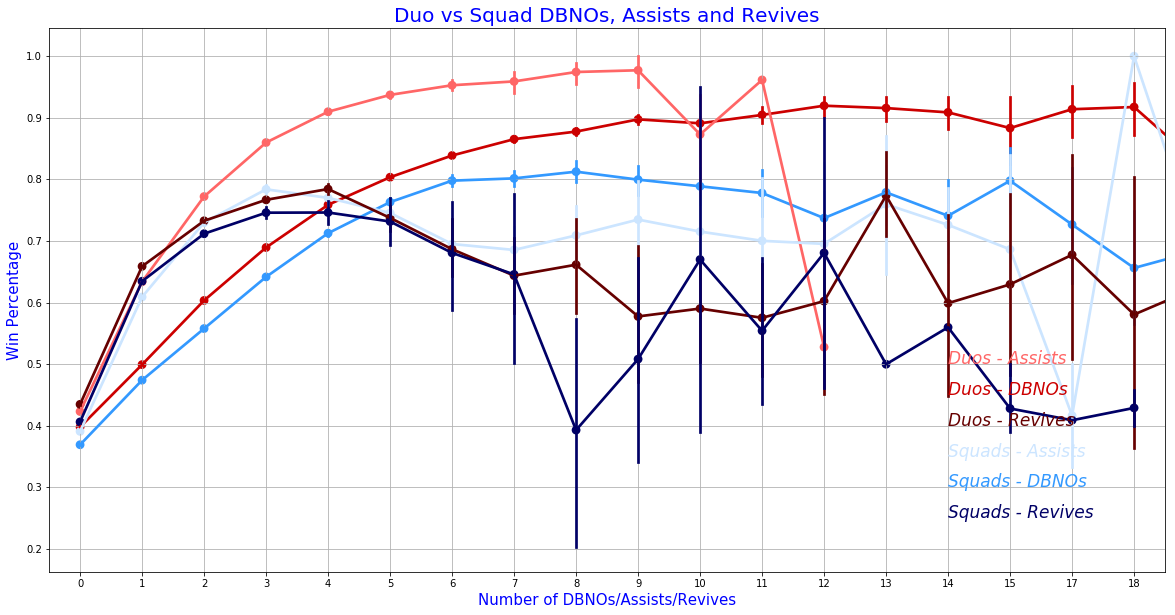

In [29]:
f,ax1 = plt.subplots(figsize=(20,10))
sns.pointplot(x='DBNOs', y='winPlacePerc', data=duos, color='#CC0000', alpha=0.8)
sns.pointplot(x='DBNOs', y='winPlacePerc', data=squads, color='#3399FF', alpha=0.8)
sns.pointplot(x='assists', y='winPlacePerc', data=duos, color='#FF6666', alpha=0.8)
sns.pointplot(x='assists', y='winPlacePerc', data=squads, color='#CCE5FF', alphs=0.8)
sns.pointplot(x='revives', y='winPlacePerc', data=duos, color='#660000', alphs=0.8)
sns.pointplot(x='revives', y='winPlacePerc', data=squads, color='#000066', alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='#FF6666',fontsize = 17,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assists/Revives', fontsize=15, color='blue')
plt.ylabel('Win Percentage', fontsize=15, color='blue')
plt.title('Duo vs Squad DBNOs, Assists and Revives', fontsize=20, color='blue')
plt.grid()
plt.show()

### Pearson correlation between variables

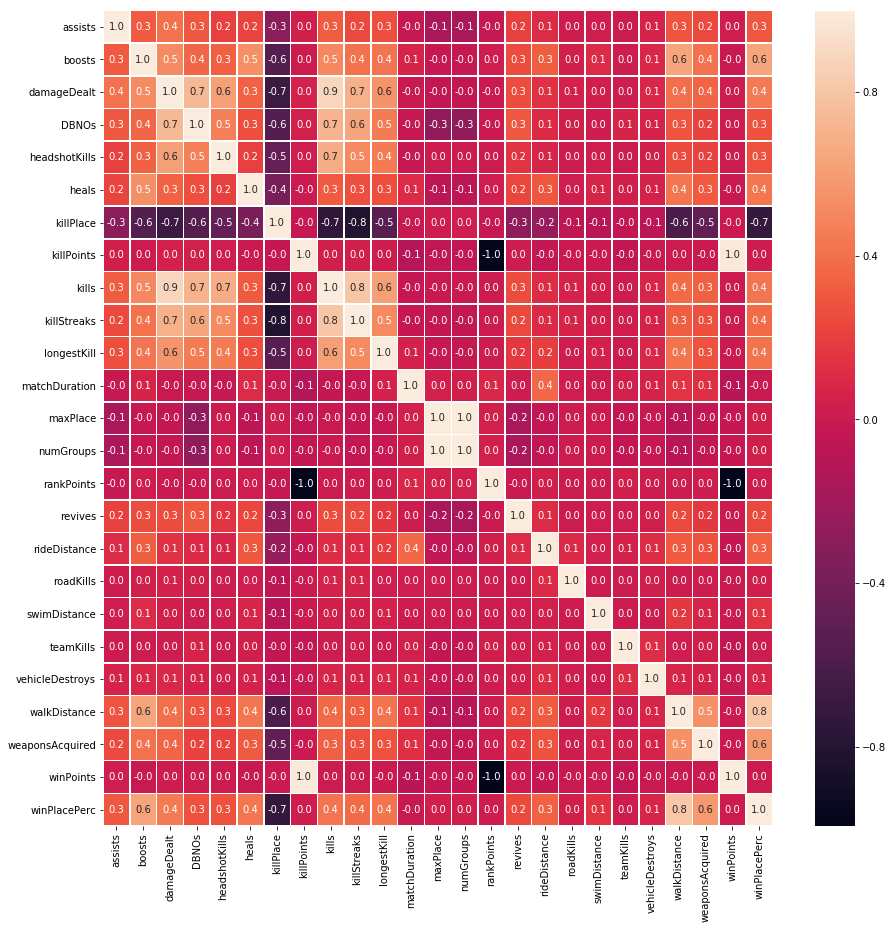

In [30]:
f,ax = plt.subplots(figsize=(15,15))
sns.heatmap(train.corr(), annot=True, linewidth=.5, fmt='.1f', ax=ax)
plt.show()

由热力图可以看出，与winPlacePerc呈正相关最大的特征为walkDistance， 呈负相关最大的特征为killPlace。

挑选5个与目标正相关最大的特征进行分析。

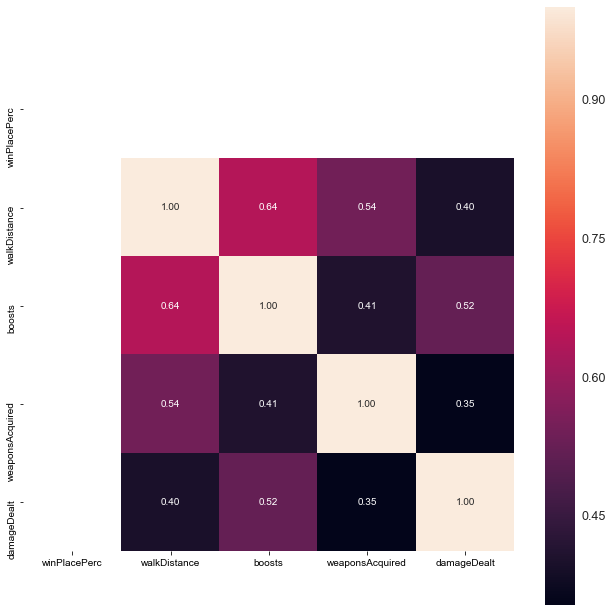

In [31]:
k = 5 #热力图的变量数
f,ax = plt.subplots(figsize=(11,11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
# np.corrcoef: 计算数据皮尔逊积矩相关系数
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Feature Engineering

生成一个变量playersJoined，说明一局比赛有多少玩家。

In [32]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

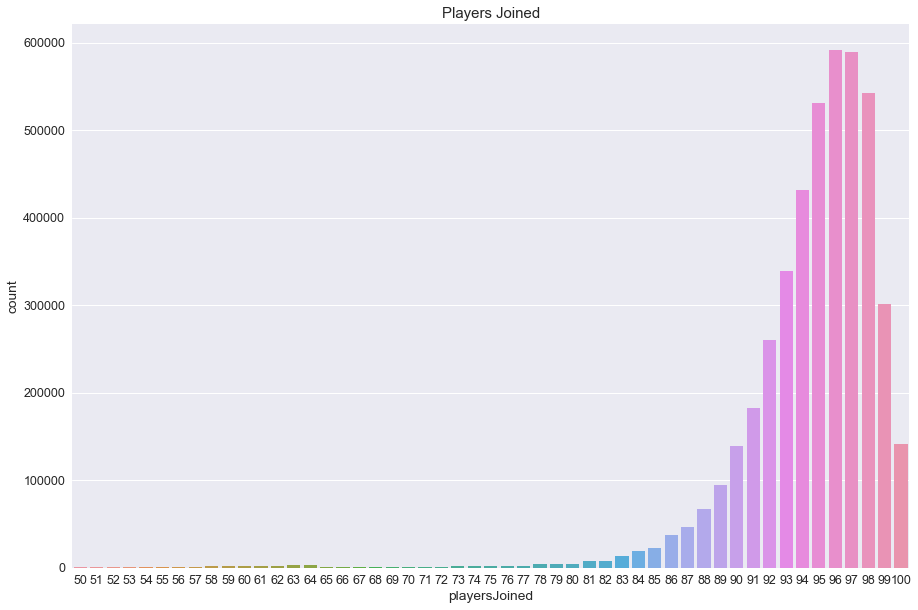

In [33]:
data = train.copy()
data = data[data['playersJoined'] > 49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title('Players Joined', fontsize=15)
plt.show()

下面对击杀数kills和造成伤害damageDealt进行调整改进。

In [34]:
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train[['playersJoined','kills','killsNorm','damageDealt','damageDealtNorm']][5:8]

,playersJoined,kills,killsNorm,damageDealt,damageDealtNorm
5,95,1,1.05,100.000,105.00000
6,97,0,0.00,0.000,0.00000
7,96,0,0.00,8.538,8.87952


新建属性healsAndBoosts：heals与boosts之和，totalDistance：walkDistance、rideDistance与swimDistance之和。

In [35]:
train['healsAndBoosts'] = train['heals'] + train['boosts']
train['totalDistance'] = train['walkDistance'] + train['rideDistance'] + train['swimDistance']

In [36]:
train['boostsPerWalkDistance'] = train['boosts']/(train['walkDistance']+1)
# +1 是为了避免walkDistance为0带来的计算错误
train['boostsPerWalkDistance'].fillna(0, inplace=True)
train['healsPerWalkDistance'] = train['heals']/(train['walkDistance']+1)
train['healsPerWalkDistance'].fillna(0, inplace=True)
train['healsAndBoostsPerWalkDistance'] = train['healsAndBoosts']/(train['walkDistance']+1)
train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
train[['walkDistance', 'boosts', 'boostsPerWalkDistance' ,'heals',  'healsPerWalkDistance', 'healsAndBoosts', 'healsAndBoostsPerWalkDistance']][20:30]

,walkDistance,boosts,boostsPerWalkDistance,heals,healsPerWalkDistance,healsAndBoosts,healsAndBoostsPerWalkDistance
20,1794.0,4,0.002228,8,0.004457,12,0.006685
21,580.1,0,0.000000,0,0.000000,0,0.000000
22,1264.0,1,0.000791,3,0.002372,4,0.003162
23,2727.0,6,0.002199,2,0.000733,8,0.002933
24,3503.0,3,0.000856,1,0.000285,4,0.001142
25,2711.0,4,0.001475,4,0.001475,8,0.002950
26,15.3,0,0.000000,0,0.000000,0,0.000000
27,1933.0,4,0.002068,2,0.001034,6,0.003102
28,3855.0,6,0.001556,1,0.000259,7,0.001815
29,0.0,0,0.000000,0,0.000000,0,0.000000


依据上文，同样创建属性"killsPerWalkDistance"。

In [37]:
train['killsPerWalkDistance'] = train['kills']/(train['walkDistance']+1)
train['killsPerWalkDistance'].fillna(0, inplace=True)
train[['kills','walkDistance','rideDistance','killsPerWalkDistance','winPlacePerc',]].sort_values(by='killsPerWalkDistance').tail(10)

,kills,walkDistance,rideDistance,killsPerWalkDistance,winPlacePerc
4115816,29,0.0,0.0,29.0,0.7500
3083358,30,0.0,0.0,30.0,0.7500
422093,30,0.0,0.0,30.0,1.0000
2394021,31,0.0,0.0,31.0,0.5385
3057746,31,0.0,0.0,31.0,0.7500
2998470,35,0.0,0.0,35.0,1.0000
1158891,36,0.0,0.0,36.0,0.5833
3062788,36,0.0,0.0,36.0,0.8667
1068513,38,0.0,0.0,38.0,0.8333
1702541,43,0.0,0.0,43.0,1.0000


没有任何移动却击杀了大量敌人，很明显是开挂了。

为Solos、Duos和Squads创建一个列。

In [38]:
train['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in train['numGroups']]

In [41]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,healsAndBoosts,totalDistance,boostsPerWalkDistance,healsPerWalkDistance,healsAndBoostsPerWalkDistance,killsPerWalkDistance,team
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,96,0.00,0.0000,0,244.8000,0.0,0.0,0.0,0.000000,2
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,91,0.00,99.7023,0,1445.0445,0.0,0.0,0.0,0.000000,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,98,0.00,69.3600,0,161.8000,0.0,0.0,0.0,0.000000,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,91,0.00,35.8610,0,202.7000,0.0,0.0,0.0,0.000000,2
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,97,1.03,103.0000,0,49.7500,0.0,0.0,0.0,0.019704,1


通过以上的分析，我们选择出以下特征进行模型训练：killsNorm, DBNOs, assists, revives, weaponAcquired, damageDealtNorm, totalDistance, healsAndBoosts, killsPerWalkDistance, team, healsAndBoostsPerWalkDistance。

### 训练模型

In [96]:
features = ['killsNorm', 'DBNOs','revives','weaponsAcquired','damageDealtNorm','totalDistance','healsAndBoosts','killsPerWalkDistance','team','healsAndBoostsPerWalkDistance']
train_X = train[features]
test = pd.read_csv('./data/test.csv')
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100+1)
test['totalDistance'] = test['walkDistance']+test['rideDistance']+test['swimDistance']
test['healsAndBoosts'] = test['heals']+test['boosts']
test['killsPerWalkDistance'] = test['kills']/(test['totalDistance']+1)
test['killsPerWalkDistance'].fillna(0,inplace=True)
test['healsAndBoostsPerWalkDistance'] = test['healsAndBoosts']/(test['totalDistance']+1)
test['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
test['team'] = [1 if i > 50 else 2 if (i>25&i<=50) else 4 for i in test['numGroups']]
test_X = test[features]

In [117]:
data = train.copy()
data[pd.isnull(data['winPlacePerc'])==True] = data['winPlacePerc'].mean()

In [116]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(train_X, train_y)
predictions = rf_model.predict(test_X)
pre = pd.DataFrame({'Id':test['Id'], 'winPlacePerc':predictions})
pre.to_csv('Submission.csv', index=False)